# Flow Meter Data Processing Script #

This script takes as input a csv file from the Alicat Flow Meter Device. Users must convert the .txt file into a .csv file so that the code can properly run. Remove the random signal in the temperature column so that the code below can run.

## Load Data from Flow Meter ##

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('Alicat Data Log_05-16-2019_15-21-10_PM JAJ part 2.csv')

In [2]:
data.head()

,Time Stamp,Absolute Pressure [PSIA],Temperature [C],Volumetric [mL/s],Mass Flow [SCCM],Gas Selected,Unnamed: 6,grad t,grad_p
0,21:10.7,14.76,25.41,0.0,0.0,N2,NaN,0.000001,0.0
1,21:10.8,14.76,25.41,0.0,0.0,N2,NaN,0.000001,0.0
2,21:10.8,14.76,25.41,0.0,0.0,N2,NaN,0.000001,0.0
3,21:10.8,14.76,25.41,0.0,0.0,N2,NaN,0.000002,0.0
4,21:10.9,14.76,25.41,0.0,0.0,N2,NaN,0.000002,0.0


In [3]:
data.columns

Index(['Time Stamp', 'Absolute Pressure [PSIA]', 'Temperature [C]',
       'Volumetric [mL/s]', 'Mass Flow [SCCM]', 'Gas Selected', 'Unnamed: 6',
       'grad t', 'grad_p'],
      dtype='object')

In [4]:
data['Time Stamp'].head()

0    21:10.7
1    21:10.8
2    21:10.8
3    21:10.8
4    21:10.9
Name: Time Stamp, dtype: object

In [5]:
data['Absolute Pressure [PSIA]'].head()

0    14.76
1    14.76
2    14.76
3    14.76
4    14.76
Name: Absolute Pressure [PSIA], dtype: float64

# Graph Data - Without Preprocessing #

## Pressure Data ##

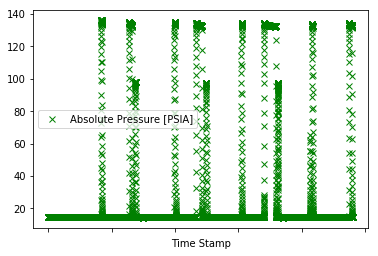

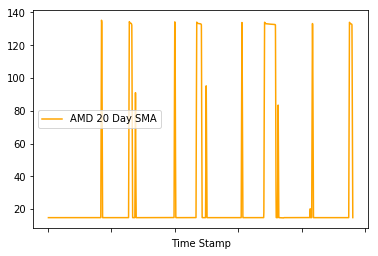

In [6]:
%matplotlib inline

avg_win = 100

P_max = data['Absolute Pressure [PSIA]'].max()
P_min = data['Absolute Pressure [PSIA]'].min()
P_std = data['Absolute Pressure [PSIA]'].std()
data['rolling_mean_p'] = data['Absolute Pressure [PSIA]'].rolling(window=avg_win).mean()


plt = data.plot(x='Time Stamp', y='Absolute Pressure [PSIA]', style=['gx','r.'])
plt2 = data.plot(x='Time Stamp', y='rolling_mean_p', label='AMD 20 Day SMA', color='orange')

fig1 = plt.get_figure()
#fig1.savefig("output1.png")

## Temperature Data ##

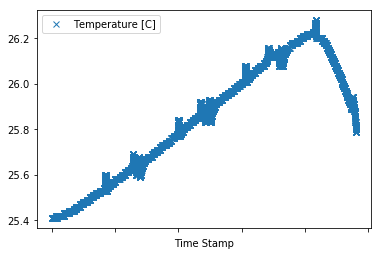

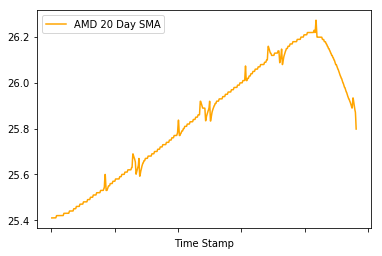

In [7]:
%matplotlib inline

T_max = data['Temperature [C]'].max()
T_min = data['Temperature [C]'].min()
T_std = data['Temperature [C]'].std()

data['rolling_mean_t'] = data['Temperature [C]'].rolling(window=avg_win).mean()
#plt.plot(df.ds, rolling_mean, label='AMD 20 Day SMA', color='orange')

plt = data.plot(x='Time Stamp', y='Temperature [C]', style=['x','r.'])

plt2 = data.plot(x='Time Stamp', y='rolling_mean_t', label='AMD 20 Day SMA', color='orange')


#plt.savefig('pie')
fig2 = plt.get_figure()
#fig2.savefig("output2.png")

In [8]:
data.columns

Index(['Time Stamp', 'Absolute Pressure [PSIA]', 'Temperature [C]',
       'Volumetric [mL/s]', 'Mass Flow [SCCM]', 'Gas Selected', 'Unnamed: 6',
       'grad t', 'grad_p', 'rolling_mean_p', 'rolling_mean_t'],
      dtype='object')

## Mass Flow [SCCM] ##

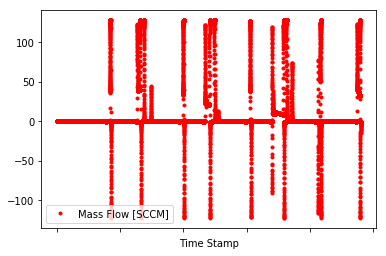

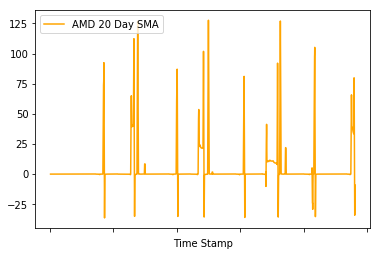

In [9]:
mass_flow_max = data['Mass Flow [SCCM]'].max()
mass_flow_min = data['Mass Flow [SCCM]'].min()
mass_flow_std = data['Mass Flow [SCCM]'].std()

data['rolling_mean_mf'] = data['Mass Flow [SCCM]'].rolling(window=avg_win).mean()

plt = data.plot(x='Time Stamp', y='Mass Flow [SCCM]', style=['r.'])
plt2 = data.plot(x='Time Stamp', y='rolling_mean_mf', label='AMD 20 Day SMA', color='orange')

fig3 = plt.get_figure()
fig3.savefig("output3.png")

## Volumetric Flow [ml/s] ##

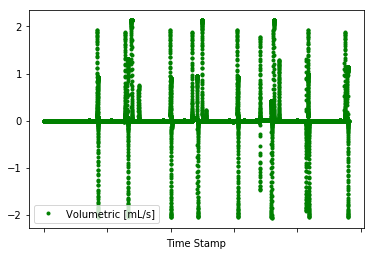

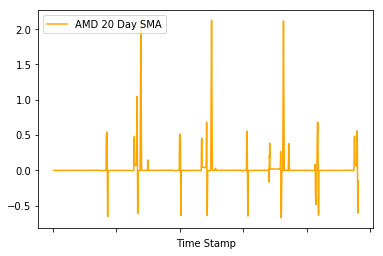

In [10]:
vol_flow_max = data['Volumetric [mL/s]'].max()
vol_flow_min = data['Volumetric [mL/s]'].min()
vol_flow_std = data['Volumetric [mL/s]'].std()

data['rolling_mean_vf'] = data['Volumetric [mL/s]'].rolling(window=avg_win).mean()

plt = data.plot(x='Time Stamp', y='Volumetric [mL/s]', style=['g.'])
plt2 = data.plot(x='Time Stamp', y='rolling_mean_vf', label='AMD 20 Day SMA', color='orange')

fig4 = plt.get_figure()
fig4.savefig("output4.png")

# Get Maximum Readings #

In [11]:
T_max

26.280000000000001

In [12]:
vol_flow_max #mL/s

2.133

In [13]:
mass_flow_max #SCCM

128.0

In [14]:
P_max #PSIA

136.09

## Separate Peaks ##

### Prepare time data ###

In [170]:
import numpy as np
data['Time Stamp'].head(5)

time_arr = np.array(data['Time Stamp'])
time_arr

array(['21:10.7', '21:10.8', '21:10.8', ..., '47:09.3', '47:09.4',
       '47:09.4'], dtype=object)

### Build Helper Function to Convert String into Time ##

In [166]:
def convert_str_t(str_time, units = 'milliseconds'):
    
## '20:00.00'
    hours = float(str_time[0:2])
    #print(hours)
    minutes = float(str_time[3:])
    #print(minutes)
    if units == 'seconds':
        total_seconds = float(hours * 60 * 60 + minutes * 60)
        return total_seconds
    
    elif units == 'milliseconds':
        total_milliseconds = float((hours * 60 * 60 + minutes * 60)*1000)
        return total_milliseconds
    
    elif units == 'hours':
        total_hours = hours
        return total_hours
        

##Debug test cases
#total_time = convert_str_t('21:12.4', 'seconds') 
#diff_time = convert_str_t('21:12.45787', 'milliseconds') - convert_str_t('21:12.34567', 'milliseconds') #resolut
#diff_time

In [185]:
import numpy as np
press_arr = np.array(data['rolling_mean_p'])
massflow_arr = np.array(data['rolling_mean_mf'])
volflow_arr = np.array(data['rolling_mean_vf'])
temp_arr = np.array(data['rolling_mean_t'])

time_arr = np.array(data['Time Stamp'])
len(press_arr)

48073

### Build time array starting at t=0 ###

In [186]:
time_arr_s = []
time = [] #formatted time starting from t=0
for idx, ele in enumerate(time_arr):
    time_arr_s.append(convert_str_t(ele))
    
for idx, ele in enumerate(time_arr_s):
    time.append(time_arr_s[idx]) #- time_arr_s[0])

time = np.array(time)

In [187]:
time

array([  7.62420000e+07,   7.62480000e+07,   7.62480000e+07, ...,
         1.69758000e+08,   1.69764000e+08,   1.69764000e+08])

In [188]:
press_arr

array([     nan,      nan,      nan, ...,  14.7865,  14.7829,  14.78  ])

In [189]:
len(time_arr_s)

48073

## Subplots of Averaged Data ## 

<function matplotlib.pyplot.show>

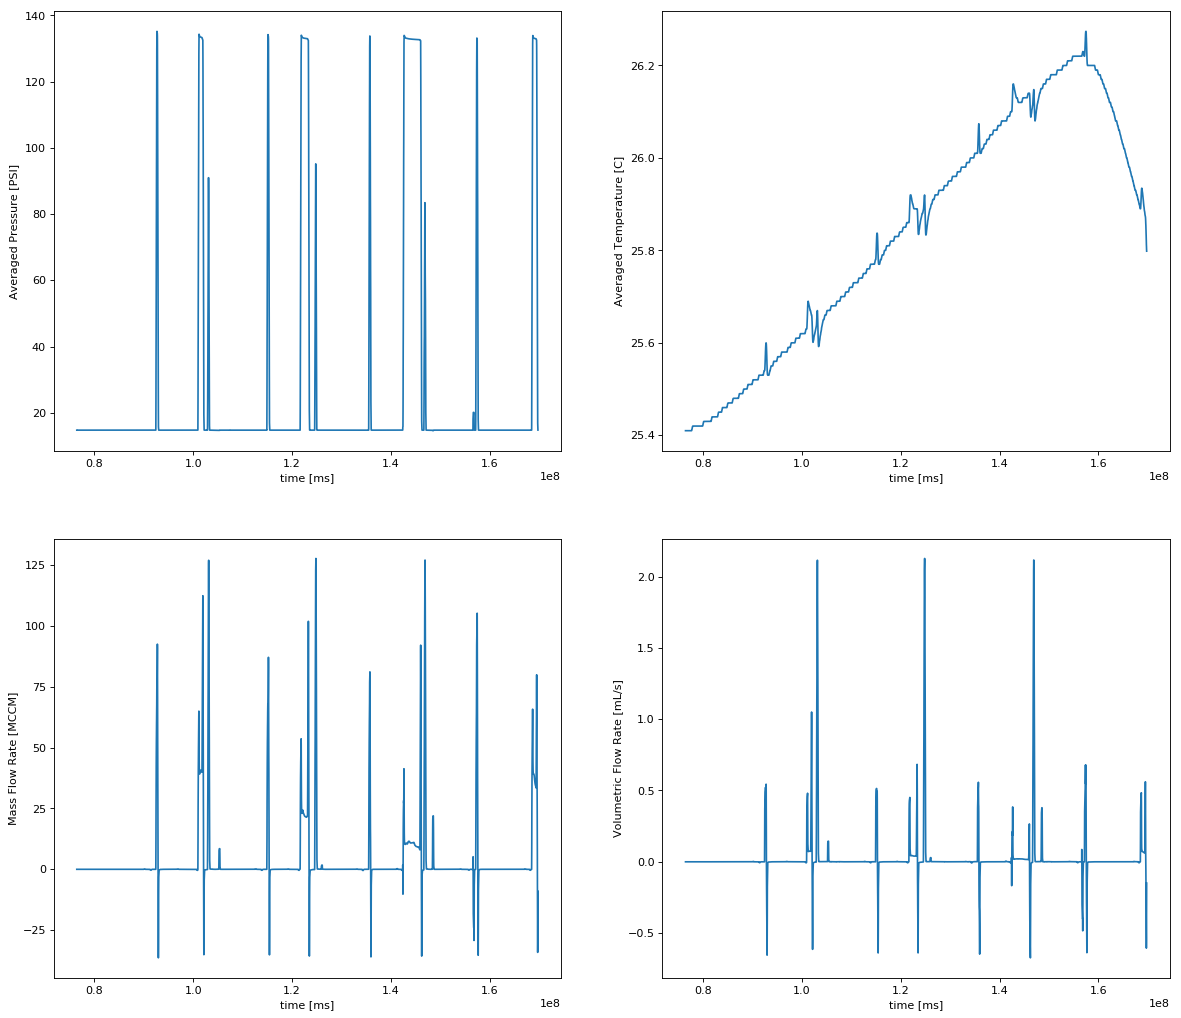

In [190]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

#plt.plot(time, press_arr)
plt.subplot(2, 2, 1)
plt.plot(time, press_arr)
plt.xlabel('time [ms]')
plt.ylabel('Averaged Pressure [PSI]')

plt.subplot(2, 2, 2)
plt.plot(time, temp_arr)
plt.xlabel('time [ms]')
plt.ylabel('Averaged Temperature [C]')

plt.subplot(2, 2, 3)
plt.plot(time, massflow_arr)
plt.xlabel('time [ms]')
plt.ylabel('Mass Flow Rate [MCCM]')

plt.subplot(2, 2, 4)
plt.plot(time, volflow_arr)
plt.xlabel('time [ms]')
plt.ylabel('Volumetric Flow Rate [mL/s]')

plt.show

### Peak Analysis Logic ###

1. Scan array & identify peaks left-to-right
2. Identify start and end indices of peak detected
3. Build new peak array
4. Dynamically plot peaks based on N peaks
5. Calculate numbers (max pressure & graph on the plot, duration of peak


In [191]:
def remove_nans(p):
    '''Function that removes nan values from array data'''
    if len(p) > 0:
        p = p[np.logical_not(np.isnan(p))]
    return p

In [192]:
def check_pressure_peak(p, p_threshold=14.7):
    
    '''Function that checks if a global maximum exists that is significantly above atmostpheric pressure.
Returns a boolean value True if a peak in the dataset exists.'''
    #p = remove_nans(p)
    
    if (np.max(p) - p_threshold > 100):
        flag = True
    else: 
        flag = False

    return flag

In [193]:
press_arr = np.array(data['rolling_mean_p'])
#preprocess 
press_arr = remove_nans(press_arr)
check_pressure_peak(press_arr)

True

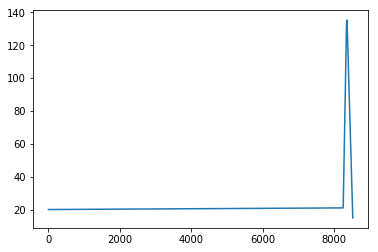

In [194]:
def find_pressure_peak(p, t, p_threshold):
    '''Finds the first peak in a series of pressure peaks in a time series dataset of flow meter data of uVS chips 
       during transfection experiments and returns an array of all the elements in that peak''' 
    t = list(t) #convert to list to perform operations on it
    t_stamp = []
    pk = []
    p = [round(x,1) for x in p]
    first_idx = 0
    last_idx = 0 
    
    for i, ele in enumerate(list(p)):
        if i % 10 == 0:
            diff = p[i] - p[i-1]
            diff2 = p[i] - p_threshold
            #print(i, diff, diff2)
            
        if  diff2 > 2.0 and diff >= 0.1:
            pk.append(ele)
            t_stamp.append(i) 
            first_idx = t_stamp[0]
            #print(t_stamp)
            
        if diff < 0.0 and diff2 > .1 and diff2 < 1.0:
            pk.append(ele)
            t_stamp.append(i)
            last_idx = i
            #print(t_stamp)
            break 
            
    #Make time start from t=0 for the peak identified
    for j, ele in enumerate(t_stamp):
        t_stamp[j] = t_stamp[j] - t_stamp[0]
    
    return pk, t_stamp, first_idx, last_idx
       
pk, t_stamp, first_idx, last_idx = find_pressure_peak(press_arr, time, 14.7)
plt.plot(t_stamp, pk)


from collections import deque

new_arr = []
var_arr = [1,2,3,5,6]

def clear_elements(arr, num):
    '''function clears arbitary length array of elements. Removes elements in an array and returns
    arr without the number of elements requested.'''
    
    if num > len(arr):
        return print('ERROR, please use a number less than the length of the array')
    deq_arr = deque(arr)
    i=0
    while i < num:
        deq_arr.popleft()
        i += 1
    return list(deq_arr)
    
a=clear_elements(var_arr, 1) 

new_arr.append(a)
new_arr?

## Building Processing Script ##

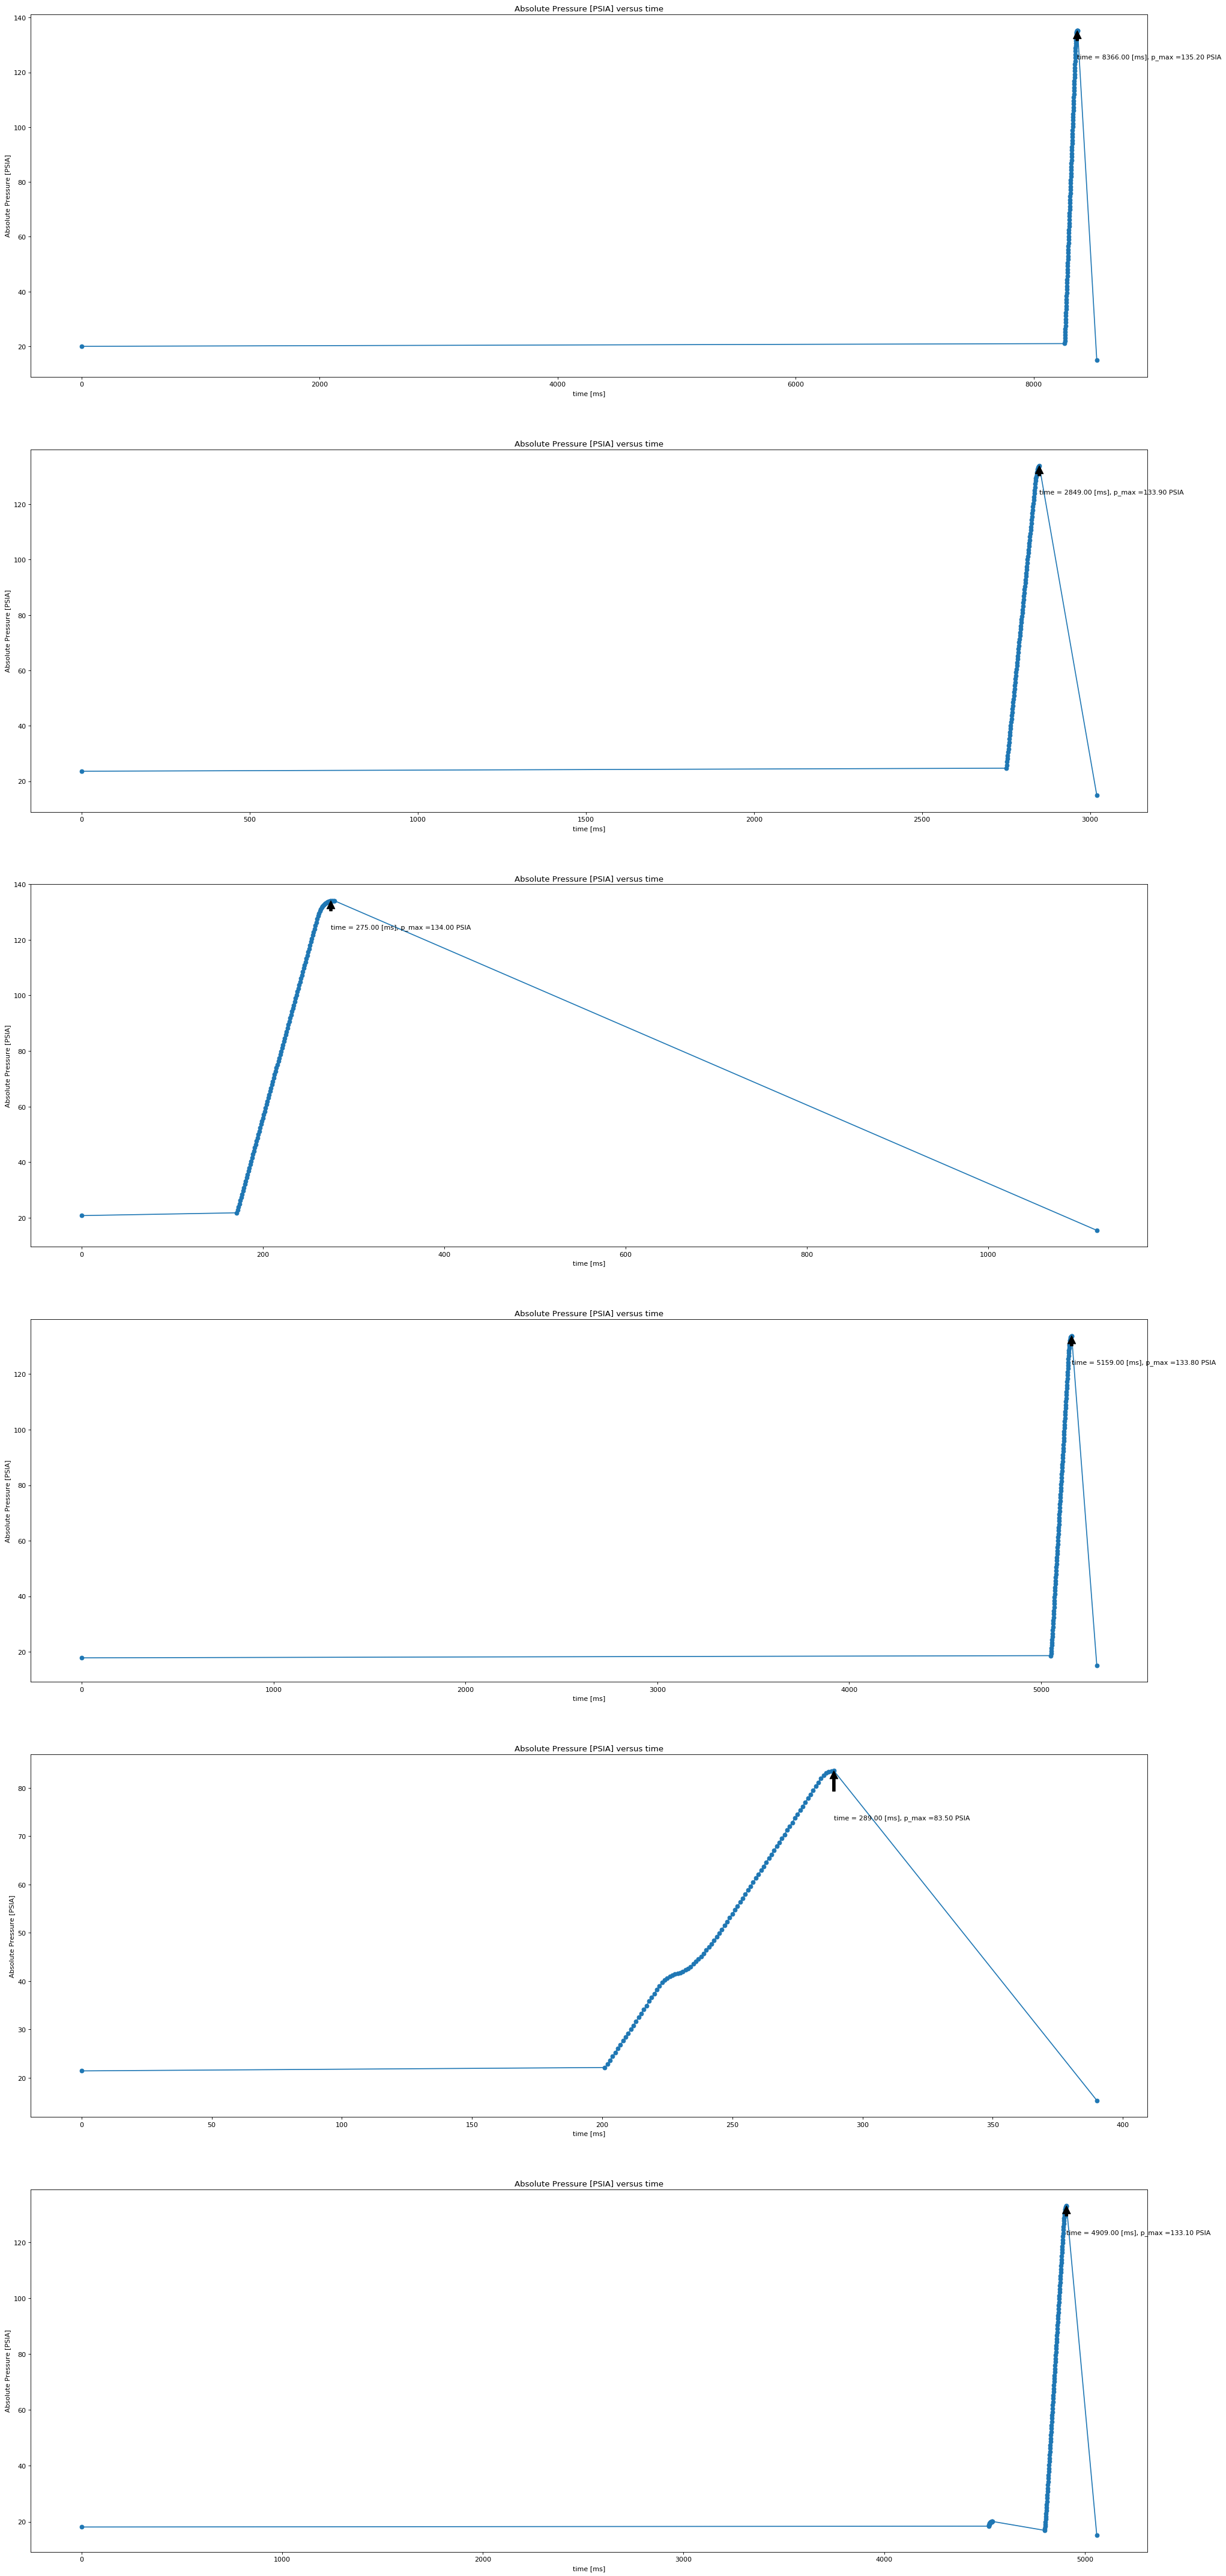

In [198]:
from collections import deque
fig=plt.figure(figsize=(30, 70), dpi= 80, facecolor='w', edgecolor='k')

press_arr = np.array(data['rolling_mean_p'])
press_arr = remove_nans(press_arr)

temp = []
temp_time = []
#num_peaks = 15 ##write a function to calculate peaks

for i in range(num_peaks):    
    if len(press_arr) > 0: 
        press_arr = press_arr[last_idx:]
        pk, t_stamp, first_idx, last_idx = find_pressure_peak(press_arr, time, p_threshold=14.7)
        
        if last_idx != 0:
            #print(last_idx)
            press_arr = press_arr[last_idx:]
            temp.append(pk)
            temp_time.append(t_stamp)
        #press_arr = clear_elements(press_arr[last_idx:, len(pk))
        #pk = clear_elements(pk, len(pk))
        #print(last_idx) #THE INDEX IS CHANGING EVERYTHING YOU INDEX FROM PRESS_ARR again. substract by starting time po
        ##THE INDEX IS CHANGING EVERYTHING YOU INDEX FROM PRESS_ARR again. substract by starting time point

for j in range(len(temp)):
    plt.subplot(len(temp), 1, j+1)
    plt.title('Absolute Pressure [PSIA] versus time')
    plt.xlabel('time [ms]')
    plt.ylabel('Absolute Pressure [PSIA]')
    
    pmax = max(temp[j])
    pidx = temp[j].index(pmax)
    tmax = temp_time[j][pidx]
    text= "time = {:.2f} [ms], p_max ={:.2f} PSIA".format(tmax, pmax)

    plt.annotate(text, xy=(tmax, pmax), xytext=(tmax, pmax-10), arrowprops=dict(facecolor='black', shrink=0.5))
                 
    plt.plot(temp_time[j], temp[j], marker='o')

    #plt.grid(True, lw = 2, ls = '--', c = '.75')

plt.show()